# Comparision to single-cell foundation models

In [ ]:
!pip install scanpy

In [1]:
from os.path import join

import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import dask.dataframe as dd

from scipy.sparse import csr_matrix
from tqdm.auto import tqdm

## scGPT evaluation

### Convert to h5ad files

In [2]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'
SAVE_PATH = '/mnt/dssfs02/scGPT-splits'

In [3]:
def get_count_matrix(ddf):
    x = (
        ddf['X']
        .map_partitions(
            lambda xx: pd.DataFrame(np.vstack(xx.tolist())), 
            meta={col: 'f4' for col in range(19331)}
        )
        .to_dask_array(lengths=[1024] * ddf.npartitions)
    )
    
    return x


In [4]:
n_cells_train = 1_500_000

ddf_train = dd.read_parquet(join(DATA_PATH, 'train'), split_row_groups=True)
x_train = get_count_matrix(ddf_train)[:n_cells_train, :]
y_train = dd.read_parquet(join(DATA_PATH, 'train'), columns=['cell_type']).compute().iloc[:n_cells_train]

ddf_test = dd.read_parquet(join(DATA_PATH, 'test'), split_row_groups=True)
x_test = get_count_matrix(ddf_test)
y_test = dd.read_parquet(join(DATA_PATH, 'test'), columns=['cell_type']).compute()

var = pd.read_parquet(join(DATA_PATH, 'var.parquet'))

#### Training data

In [ ]:
# run inference in batches to save memory

for i, idxs in tqdm(enumerate(np.array_split(np.arange(x_train.shape[0]), 10))):
    # data is already normalized
    anndata.AnnData(
        X=x_train[idxs, :].map_blocks(csr_matrix).compute(), 
        var=var.set_index('feature_name'),
        obs=y_train.iloc[idxs]
    ).write_h5ad(join(SAVE_PATH, 'train', f'{i}.h5ad'))


#### Test data

In [ ]:
for i, idxs in tqdm(enumerate(np.array_split(np.arange(x_test.shape[0]), 30))):
    # data is already normalized
    anndata.AnnData(
        X=x_test[idxs, :].map_blocks(csr_matrix).compute(), 
        var=var.set_index('feature_name'),
        obs=y_test.iloc[idxs]
    ).write_h5ad(join(SAVE_PATH, 'test', f'{i}.h5ad'))


### Get embeddings from scGPT

In [6]:
SAVE_PATH = '/mnt/dssfs02/scGPT-splits'

In [7]:
from pathlib import Path
from os.path import join

import scgpt as scg
import anndata
import scanpy as sc

In [9]:
model_dir = Path("/mnt/dssfs02/scTab-checkpoints/scGPT")
cell_type_key = "cell_type"
gene_col = "index"

#### Training data

In [ ]:
for i in range(10):
    adata = sc.read_h5ad(join(SAVE_PATH, 'train', f'{i}.h5ad'))
    adata = scg.tasks.embed_data(
        adata,
        model_dir,
        cell_type_key=cell_type_key,
        gene_col=gene_col,
        batch_size=64,
        return_new_adata=True,
    ).write_h5ad(join(SAVE_PATH, 'train', f'{i}_embed.h5ad'))


#### Test data

In [ ]:
for i in range(30):
    adata = sc.read_h5ad(join(SAVE_PATH, 'test', f'{i}.h5ad'))
    adata = scg.tasks.embed_data(
        adata,
        model_dir,
        cell_type_key=cell_type_key,
        gene_col=gene_col,
        batch_size=64,
        return_new_adata=True,
    ).write_h5ad(join(SAVE_PATH, 'test', f'{i}_embed.h5ad'))


### Evaluate scGPT embeddings

In [2]:
from tqdm import tqdm

#### Train Linear model

In [3]:
from os.path import join

import anndata
import scanpy as sc
import numpy as np

from cuml.linear_model import LogisticRegression

In [4]:
SAVE_PATH = '/mnt/dssfs02/scGPT-splits'
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

In [ ]:
X = []
y = []


for i in range(10):
    adata = sc.read_h5ad(join(SAVE_PATH, 'train', f'{i}_embed.h5ad'))
    X.append(adata.X)
    y.append(adata.obs.cell_type.to_numpy())

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

In [6]:
clf_list = []

for i in tqdm(range(5)):
    clf_list.append(LogisticRegression(class_weight='balanced', max_iter=5000, C=1000).fit(X, y))


100%|██████████| 5/5 [40:45<00:00, 489.17s/it]


#### Evaluate on test data

In [7]:
import pandas as pd
from sklearn.metrics import classification_report
from statistics import mean, stdev

from utils import correct_labels

In [8]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))

In [ ]:
X_test = []
y_test = []


for i in range(30):
    adata = sc.read_h5ad(join(SAVE_PATH, 'test', f'{i}_embed.h5ad'))
    X_test.append(adata.X)
    y_test.append(adata.obs.cell_type.to_numpy())

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [10]:
clf_reports = []

for clf in clf_list:
    preds = clf.predict(X_test)
    preds_corr = correct_labels(y_test, preds, cell_type_hierarchy)
    clf_reports.append(pd.DataFrame(classification_report(y_test, preds_corr, output_dict=True)).T)


In [11]:
f1_scores_scgpt = [clf_report.loc['macro avg', 'f1-score'] for clf_report in clf_reports]
print(f'{mean(f1_scores_scgpt):.4f}±{stdev(f1_scores_scgpt):.4f}')

0.7298±0.0036


In [12]:
f1_scores_scgpt

[0.7275267270698612,
 0.7336942080372159,
 0.7298628517039708,
 0.7327396273235566,
 0.7251052094677389]

### Evaluate predictions from fine-tuned scGPT model

In [13]:
# see notebooks/training/scGPT-finetuning.ipynb for code for fine-tuning + inference of finetuned model

In [14]:
from sklearn.metrics import classification_report
from utils import correct_labels

In [15]:
y_pred = np.load('model_eval_cache/preds_test_scGPT_finetuned.npy')
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()

In [16]:
y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)

In [17]:
clf_report = pd.DataFrame(classification_report(y_true, y_pred_corr, output_dict=True, zero_division=0.)).T
clf_report_overall = clf_report.iloc[-3:].copy()
clf_report_per_class = clf_report.iloc[:-3].copy()

f1_scores_scgpt_finetuned = [clf_report_overall.loc['macro avg', 'f1-score']]
f1_scores_scgpt_finetuned

[0.7492727747528732]

## Evaluate PCA embeddings

In [18]:
from os.path import join

import numpy as np
import dask.dataframe as dd

from cuml.linear_model import LogisticRegression

In [19]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

### Train linear model 

In [20]:
n_cells_train = 1_500_000  # take same amount of cells as for scGPT + celltypist

x_pca = np.load(join(DATA_PATH, 'pca/x_pca_training_train_split_256.npy'))[:n_cells_train, :]  

In [21]:
y_pca = dd.read_parquet(join(DATA_PATH, 'train'), columns=['cell_type']).compute().iloc[:n_cells_train]

In [22]:
y_pca = y_pca.to_numpy().flatten()

In [23]:
clf_list_pca = []

for i in tqdm(range(5)):
    clf_list_pca.append(LogisticRegression(class_weight='balanced', max_iter=15000, C=1000).fit(x_pca, y_pca))


100%|██████████| 5/5 [1:16:17<00:00, 915.46s/it]


### Evaluate on test data

In [24]:
import pandas as pd
from sklearn.metrics import classification_report
from statistics import mean, stdev

from utils import correct_labels

In [25]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))

In [26]:
x_pca_test = np.load(join(DATA_PATH, 'pca/x_pca_training_test_split_256.npy'))
y_pca_test = dd.read_parquet(join(DATA_PATH, 'test'), columns=['cell_type']).compute()

In [27]:
y_pca_test = y_pca_test.to_numpy().flatten()

In [28]:
clf_reports_pca = []

for clf in clf_list_pca:
    preds = clf.predict(x_pca_test)
    preds_corr = correct_labels(y_pca_test, preds, cell_type_hierarchy)
    clf_reports_pca.append(pd.DataFrame(classification_report(y_pca_test, preds_corr, output_dict=True)).T)


In [29]:
f1_scores_pca = [clf_report.loc['macro avg', 'f1-score'] for clf_report in clf_reports_pca]
print(f'{mean(f1_scores_pca):.4f}±{stdev(f1_scores_pca):.4f}')

0.7525±0.0005


In [30]:
f1_scores_pca

[0.7529892568627892,
 0.752437003611239,
 0.7522722497824025,
 0.7529443963182549,
 0.7518038335833493]

## Evaluate UCE model

In [1]:
from os.path import join

import anndata
import numpy as np
import pandas as pd
import dask.dataframe as dd

In [2]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

### Retieve embeddings for train and test data for UCE model

In [ ]:
!pip install -U cellxgene-census

In [3]:
import cellxgene_census
from cellxgene_census.experimental import get_embedding

In [4]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
dataset_id_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/dataset_id.parquet'))
donor_id_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/donor_id.parquet'))
tech_sample_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/tech_sample.parquet'))

In [5]:
obs_columns = ['cell_type', 'dataset_id', 'donor_id', 'tech_sample']
ddf_train = dd.read_parquet(join(DATA_PATH, 'train'), split_row_groups=True)
obs_train = dd.read_parquet(join(DATA_PATH, 'train'), columns=obs_columns).compute()
ddf_test = dd.read_parquet(join(DATA_PATH, 'test'), split_row_groups=True)
obs_test = dd.read_parquet(join(DATA_PATH, 'test'), columns=obs_columns).compute()
var = pd.read_parquet(join(DATA_PATH, 'var.parquet'))

In [6]:
obs_test['tech_sample'] = obs_test.tech_sample.replace(tech_sample_mapping.label.to_dict()).astype('category')
obs_test['cell_type'] = obs_test.cell_type.replace(cell_type_mapping.label.to_dict()).astype('category')
obs_test['dataset_id'] = obs_test.dataset_id.replace(dataset_id_mapping.label.to_dict()).astype('category')
obs_test['donor_id'] = obs_test.donor_id.replace(donor_id_mapping.label.to_dict()).astype('category')

In [7]:
obs_train['tech_sample'] = obs_train.tech_sample.replace(tech_sample_mapping.label.to_dict()).astype('category')
obs_train['cell_type'] = obs_train.cell_type.replace(cell_type_mapping.label.to_dict()).astype('category')
obs_train['dataset_id'] = obs_train.dataset_id.replace(dataset_id_mapping.label.to_dict()).astype('category')
obs_train['donor_id'] = obs_train.donor_id.replace(donor_id_mapping.label.to_dict()).astype('category')

In [8]:
PROTOCOLS = [
    "10x 5' v2", 
    "10x 3' v3", 
    "10x 3' v2", 
    "10x 5' v1", 
    "10x 3' v1", 
    "10x 3' transcription profiling", 
    "10x 5' transcription profiling"
]


COLUMN_NAMES = [
    "soma_joinid",
    "is_primary_data",
    "dataset_id", 
    "donor_id",
    "assay", 
    "cell_type", 
    "development_stage", 
    "disease", 
    "tissue", 
    "tissue_general"
]

In [9]:
census = cellxgene_census.open_soma(census_version="2023-12-15")

In [10]:
obs = (
    census["census_data"]["homo_sapiens"]
    .obs
    .read(
        column_names=COLUMN_NAMES,
        value_filter=f"is_primary_data == True and assay in {PROTOCOLS}"
    )
    .concat()
    .to_pandas()
)

In [29]:
set(obs_test.tech_sample.unique()) - set(obs.tech_sample.unique())

{'0c774045-26a7-40f8-9b07-6742d3c771c0_ac03',
 '0c774045-26a7-40f8-9b07-6742d3c771c0_ac04',
 '0c774045-26a7-40f8-9b07-6742d3c771c0_ac07',
 '0c774045-26a7-40f8-9b07-6742d3c771c0_ac09',
 '0c774045-26a7-40f8-9b07-6742d3c771c0_ac15',
 '0c774045-26a7-40f8-9b07-6742d3c771c0_ac18',
 '0c774045-26a7-40f8-9b07-6742d3c771c0_ac21',
 '87ce26ed-e5d1-44b4-81cc-cc5b709a169f_CV-056',
 '87ce26ed-e5d1-44b4-81cc-cc5b709a169f_SK-008',
 '87ce26ed-e5d1-44b4-81cc-cc5b709a169f_SK-014',
 '9ff99bf8-2524-4ab5-ab6e-4bc218e4a449_pooled [sanes2022_Hu0216,sanes2022_Hu0218]',
 '9ff99bf8-2524-4ab5-ab6e-4bc218e4a449_sanes2022_Hu0216',
 'b252b015-b488-4d5c-b16e-968c13e48a2c_SPECTRUM-OV-014',
 'b252b015-b488-4d5c-b16e-968c13e48a2c_SPECTRUM-OV-053',
 'b252b015-b488-4d5c-b16e-968c13e48a2c_SPECTRUM-OV-067',
 'b252b015-b488-4d5c-b16e-968c13e48a2c_SPECTRUM-OV-075',
 'b252b015-b488-4d5c-b16e-968c13e48a2c_SPECTRUM-OV-082',
 'b252b015-b488-4d5c-b16e-968c13e48a2c_SPECTRUM-OV-083',
 'b252b015-b488-4d5c-b16e-968c13e48a2c_SPECTRUM-OV

In [33]:
obs_test.tech_sample.nunique()

758

In [31]:
obs_test.tech_sample.nunique() - len(set(obs_test.tech_sample.unique()) - set(obs.tech_sample.unique()))

736

In [11]:
obs['tech_sample'] = (obs.dataset_id + '_' + obs.donor_id).astype('category')

In [12]:
obs_subset_test = obs.query(
    f"tech_sample in {obs_test.tech_sample.unique().tolist()} and cell_type in {obs_test.cell_type.unique().tolist()}"
)
obs_subset_train = obs.query(
    f"tech_sample in {obs_train.tech_sample.unique().tolist()} and cell_type in {obs_train.cell_type.unique().tolist()}"
)

In [13]:
rng = np.random.default_rng(seed=1)
soma_ids_train = rng.choice(obs_subset_train.soma_joinid.to_numpy(), 1_500_000, replace=False)
soma_ids_test = obs_subset_test.soma_joinid.to_numpy()

In [ ]:
embedding_uri = "s3://cellxgene-contrib-public/contrib/cell-census/soma/2023-12-15/CxG-contrib-2"
census = cellxgene_census.open_soma(census_version="2023-12-15")

In [ ]:
embeddings_train = get_embedding("2023-12-15", embedding_uri, soma_ids_train)
embeddings_test = get_embedding("2023-12-15", embedding_uri, soma_ids_test)

In [ ]:
np.save('/mnt/dssfs02/tb_logs/UCE/train_embeddings.npy', embeddings_train)
np.save('/mnt/dssfs02/tb_logs/UCE/train_soma_ids.npy', soma_ids_train)
np.save('/mnt/dssfs02/tb_logs/UCE/test_embeddings.npy', embeddings_test)
np.save('/mnt/dssfs02/tb_logs/UCE/test_soma_ids.npy', soma_ids_test)

In [ ]:
anndata.AnnData(
    X=embeddings_train,
    obs=obs_subset_train.set_index('soma_joinid').loc[soma_ids_train]
).write('/mnt/dssfs02/tb_logs/UCE/train.h5ad')

anndata.AnnData(
    X=embeddings_test,
    obs=obs_subset_test.set_index('soma_joinid').loc[soma_ids_test]
).write('/mnt/dssfs02/tb_logs/UCE/test.h5ad')

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Fit linear model on top of UCE embeddings

In [3]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

In [4]:
from os.path import join

import anndata
import numpy as np
import pandas as pd

from cuml.linear_model import LogisticRegression
from tqdm import tqdm

In [5]:
adata_train = anndata.read_h5ad('/mnt/dssfs02/tb_logs/UCE/train.h5ad')

In [6]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
inverse_mapping = {v: k for k, v in cell_type_mapping.label.to_dict().items()}
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))

In [7]:
X = adata_train.X
y = adata_train.obs.cell_type.replace(inverse_mapping).to_numpy()

In [8]:
# embeddings have nan values -> fill those with zeros
X[np.isnan(X)] = 0.

In [9]:
clf_list = []

for i in tqdm(range(4)):
    clf_list.append(LogisticRegression(class_weight='balanced').fit(X, y))


 25%|██▌       | 1/4 [06:06<18:19, 366.67s/it]

[W] [23:33:30.118823] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


 50%|█████     | 2/4 [17:48<18:47, 563.79s/it]

[W] [23:45:11.896243] L-BFGS line search failed (code 3); stopping at the last valid step


 75%|███████▌  | 3/4 [31:23<11:18, 678.56s/it]

[W] [23:58:47.018042] L-BFGS line search failed (code 3); stopping at the last valid step


100%|██████████| 4/4 [39:09<00:00, 587.29s/it]


### Evaluate on test data

In [10]:
from sklearn.metrics import classification_report
from statistics import mean, stdev

from utils import correct_labels

In [11]:
adata_test = anndata.read_h5ad('/mnt/dssfs02/tb_logs/UCE/test.h5ad')

In [12]:
x_test = adata_test.X
y_test = adata_test.obs.cell_type.replace(inverse_mapping).to_numpy()

In [13]:
x_test[np.isnan(x_test)] = 0.

In [21]:
clf_reports = []

for clf in clf_list:
    preds = []
    for x_subset in np.array_split(x_test, 10):
        preds.append(clf.predict(x_subset))
    
    preds = np.concatenate(preds)
    preds_corr = correct_labels(y_test, preds, cell_type_hierarchy)
    clf_reports.append(pd.DataFrame(classification_report(y_test, preds_corr, output_dict=True, zero_division=0.)).T)


In [22]:
f1_scores_uce = [clf_report.loc['macro avg', 'f1-score'] for clf_report in clf_reports]
print(f'{mean(f1_scores_uce):.4f}±{stdev(f1_scores_uce):.4f}')

0.7605±0.0046


In [23]:
f1_scores_uce

[0.7559451442021066,
 0.7652856214308852,
 0.7635760462072493,
 0.7571082615493979]

## Plot performance metrics 

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
model_comparision_df = pd.read_csv('model_eval_cache/model_comparision.csv', index_col=0)
f1_scores_tabnet = model_comparision_df.query('model == "tabnet"')['f1-score (macro avg.)'].tolist()

/tmp/ipykernel_1194199/169897137.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


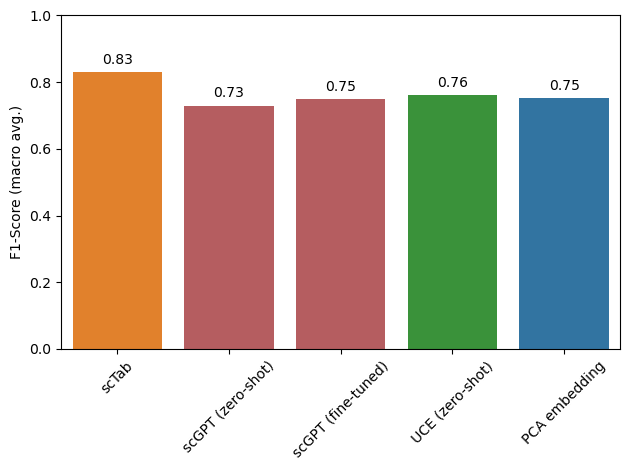

In [33]:
df = pd.DataFrame({
    'f1-score (macro avg.)': (
        f1_scores_tabnet + 
        f1_scores_scgpt + 
        f1_scores_scgpt_finetuned + 
        f1_scores_uce + 
        f1_scores_pca
    ),
    'model': (
        ['scTab'] * len(f1_scores_tabnet) + 
        ['scGPT (zero-shot)'] * len(f1_scores_scgpt) + 
        ['scGPT (fine-tuned)'] * len(f1_scores_scgpt_finetuned) + 
        ['UCE (zero-shot)'] * len(f1_scores_uce) + 
        ['PCA embedding'] * len(f1_scores_pca)
    )
})

ax = sns.barplot(
    x='model',
    y='f1-score (macro avg.)',
    #hue='model',
    data=df,
    errorbar=None,
    palette=['#ff7f0e', '#C44E52', '#C44E52', '#2ca02c', '#1f77b4']
)
ax.set_ylabel('F1-Score (macro avg.)')
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.tick_params(axis='x', labelrotation=45)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.tight_layout()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/supp_figures/foundation_model_comparision.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/supp_figures/foundation_model_comparision.png', dpi=300)